# Segmentation through local feature importance approximation

In [1]:
import numpy as np
import sys,csv,os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

import tensorflow as tf
import tensorflow.keras  as keras
import tensorflow.keras.backend as K
import tensorflow.keras.layers
from tensorflow.keras.preprocessing import image
import pandas as pd
csv.field_size_limit(sys.maxsize)
%load_ext tensorboard
logs_base_dir = "./logs"
os.makedirs(logs_base_dir, exist_ok=True)
%tensorboard --logdir {logs_base_dir}
tf.compat.v1.disable_eager_execution()


Reusing TensorBoard on port 6006 (pid 686), started 3:05:44 ago. (Use '!kill 686' to kill it.)

<IPython.core.display.Javascript object>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Hyperparams - backend network

In [3]:
NETWORK_TYPE = "InceptionV3"
NUMBER_OF_APPAREL = 27
NUMBER_OF_APPAREL_PARTS = 19
NUMBER_OF_STYLES = 92
TRAIN_SPLIT = 0.8
DATA_FRACTION = 1.0
IMG_SHAPE = (224,224)
INPUT_SHAPE = IMG_SHAPE
CHANNEL_FORMAT = 'channels_last' # channel_first better
BATCH_SIZE=150
DIR = '/content/drive/My Drive/SDD'
IMAGE_DIR = DIR+"/train_new/"
RELEARN_LAYER_BY_LAYER = True
CHECKPOINT_SUFFIX = "_v1" if(RELEARN_LAYER_BY_LAYER==True)  else "_v2"
CHECKPOINT_DIR = DIR+'/checkpoints/'+NETWORK_TYPE+CHECKPOINT_SUFFIX+".ckpt"

if(CHANNEL_FORMAT=='channels_first'): INPUT_SHAPE = (3,) + INPUT_SHAPE
else:  INPUT_SHAPE += (3,)


# Load your classification dataset here

In [4]:
def remove_csv_columns(input_csv, output_csv, exclude_column_indices):
    with open(input_csv) as file_in, open(output_csv, 'w') as file_out:
        reader = csv.reader(file_in)
        writer = csv.writer(file_out)
        writer.writerows(
            [col for idx, col in enumerate(row)
             if idx not in exclude_column_indices]
            for row in reader)
def read_dataset(input_csv=(DIR+'/train_new.csv')):
    print(input_csv)
    filenames = []
    img_sizes = []
    labels = []
    with open(input_csv) as csvfile:
        readCSV = csv.reader(csvfile, delimiter=',')
        for row in list(readCSV)[1:]:
            filenames.append(IMAGE_DIR+row[0])
            img_sizes.append(row[1:3])
            labels.append(row[3])
    return filenames,img_sizes,labels



In [6]:
new_filenames,new_img_sizes,encoded_labels = read_dataset()
data = np.concatenate((np.array(new_filenames)[:,None],encoded_labels),axis=1)
print("Number of samples:"+str(len(data)))
zero_frac = np.unique(encoded_labels,return_counts=True)[1]
zero_frac = zero_frac[0]*1.0/(zero_frac[1]+zero_frac[0])
print("Fraction of zeros: "+str(zero_frac))
label_counts = np.sum(encoded_labels,axis=0)
label_av=np.sum(label_counts)*1.0/len(label_counts)
output_weights = label_av/label_counts


Number of samples:45625
Fraction of zeros: 0.8904483003551497


# split into train/validation datasets

In [7]:
train_df = pd.DataFrame(data=data[:int(len(data)*TRAIN_SPLIT),:],  
                          columns=["fname"]+["Y"+str(i) for i in range(NUMBER_OF_APPAREL)])

val_df = pd.DataFrame(data=data[int(len(data)*TRAIN_SPLIT):,:],  
                          columns=["fname"]+["Y"+str(i) for i in range(NUMBER_OF_APPAREL)])
for i in range(NUMBER_OF_APPAREL): 
    train_df["Y"+str(i)]=pd.to_numeric(train_df["Y"+str(i)], errors='ignore')
    val_df["Y"+str(i)]=pd.to_numeric(val_df["Y"+str(i)], errors='ignore')

# construct final layers on top of the backend model

In [5]:
from tensorflow.keras.layers import Dense,GlobalAvgPool2D,BatchNormalization,Dropout
from tensorflow.keras.models import Model

def construct_model(network_type="MobileNet",freeze_base=True):
    K.clear_session()
    if(network_type == "InceptionV3"):
        from tensorflow.keras.applications.inception_v3 import InceptionV3
        from tensorflow.keras.applications.inception_v3 import preprocess_input
        base_model = InceptionV3(weights='imagenet', include_top=False,input_shape = INPUT_SHAPE)
        preprocess_input_ = preprocess_input
    elif(network_type == "MobileNet"):
        from tensorflow.keras.applications import MobileNetV2
        from tensorflow.keras.applications.mobilenet_v2 import preprocess_input 
        base_model = MobileNetV2(weights='imagenet', include_top=False,input_shape = INPUT_SHAPE)
        preprocess_input_ = preprocess_input
    x = base_model.output
    x = GlobalAvgPool2D(data_format=CHANNEL_FORMAT)(x)
    x = BatchNormalization()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.4)(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.4)(x)
    x = Dense(NUMBER_OF_APPAREL, activation='linear')(x)
    out = tf.keras.activations.sigmoid(x)

    model = Model(inputs=base_model.input, outputs=out)
    if(freeze_base==True):
        for layer in base_model.layers:
            layer.trainable = False
    return model,preprocess_input_

if(RELEARN_LAYER_BY_LAYER==True):
  model,preprocess_input_fn = construct_model(network_type=NETWORK_TYPE,freeze_base=True)
else:
  model,preprocess_input_fn = construct_model(network_type=NETWORK_TYPE,freeze_base=False)
model.summary()
for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.trainable)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
_____________

In [ ]:
train_datagen = image.ImageDataGenerator(
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        preprocessing_function=preprocess_input_fn
        )
test_datagen = image.ImageDataGenerator(
        preprocessing_function=preprocess_input_fn
)
train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,x_col="fname", 
        y_col=(["Y"+str(i) for i in range(NUMBER_OF_APPAREL)]),
        target_size=IMG_SHAPE,
        batch_size=BATCH_SIZE,
        class_mode='other',
        seed=0)
validation_generator = test_datagen.flow_from_dataframe(
        dataframe=val_df,x_col="fname", 
        y_col=(["Y"+str(i) for i in range(NUMBER_OF_APPAREL)]),
        target_size=IMG_SHAPE,
        batch_size=BATCH_SIZE,
        class_mode='other',
        seed=0)

In [6]:
# optional - read wegihts from previous attempts
model.load_weights(CHECKPOINT_DIR)

In [7]:
from tensorflow.keras.optimizers import Nadam,Adam
from tensorflow.keras.losses import CategoricalCrossentropy,BinaryCrossentropy,binary_crossentropy
from tensorflow.keras.metrics import CategoricalAccuracy,BinaryAccuracy
import datetime as dt
from tensorflow.keras.callbacks import TensorBoard,EarlyStopping,ReduceLROnPlateau,ModelCheckpoint

# define typical weighted classification loss
def loss_fn(y_true,y_pred):
    return output_weights*K.mean(binary_crossentropy(y_true,y_pred),axis=0)
metrics = [BinaryAccuracy()]

# define callbacks
tb = TensorBoard(log_dir="./logs/"+dt.datetime.now().strftime("%m%d%Y%H%M%S"),profile_batch=0)
reducelr = ReduceLROnPlateau(monitor='val_binary_accuracy',
                             factor=np.sqrt(.1),
                             patience=5,
                             verbose=1,
                             mode='auto',
                             min_delta=.0000,
                             cooldown=0,
                             min_lr=0.0000001)
earlyStop = EarlyStopping(patience=50,monitor='val_binary_accuracy',restore_best_weights=True)
checkpoint =ModelCheckpoint(CHECKPOINT_DIR,save_weights_only=True,verbose=1,save_best_only=True,monitor='val_binary_accuracy')
callbacks = [tb,reducelr,earlyStop,checkpoint]


In [ ]:
# fit model using different fine tuning strategies
if(RELEARN_LAYER_BY_LAYER==True):
  model.compile(optimizer=Nadam(),loss=BinaryCrossentropy(),metrics=metrics)
  model.fit(train_generator,
          steps_per_epoch=len(train_generator),epochs=10,
          validation_data=validation_generator,validation_steps=len(validation_generator),
          callbacks=callbacks)  
  fine_tune_at = 50   # Fine-tune from this layer onwards
  # Freeze all the layers before the `fine_tune_at` layer
  for layer in model.layers[fine_tune_at:]:
    layer.trainable = True
  model.compile(optimizer=Nadam(),loss=BinaryCrossentropy(),metrics=metrics)
  model.fit(train_generator,
          steps_per_epoch=len(train_generator),epochs=100,
          validation_data=validation_generator,validation_steps=len(validation_generator),
          callbacks=callbacks)    
else:
  model.compile(optimizer=Nadam(),loss=BinaryCrossentropy(),metrics=metrics)
  model.fit(train_generator,
          steps_per_epoch=len(train_generator),epochs=100,
          validation_data=validation_generator,validation_steps=len(validation_generator),
          callbacks=callbacks)

Epoch 1/10
244/244 [==============================] - ETA: 0s - loss: 0.2414 - binary_accuracy: 0.9104 
Epoch 00001: val_binary_accuracy improved from -inf to 0.91952, saving model to /content/drive/My Drive/SDD/checkpoints/InceptionV3_v1.ckpt
244/244 [==============================] - 16026s 66s/step - loss: 0.2414 - binary_accuracy: 0.9104 - val_loss: 0.2157 - val_binary_accuracy: 0.9195 - lr: 0.0010
Epoch 2/10
244/244 [==============================] - ETA: 0s - loss: 0.2179 - binary_accuracy: 0.9188
Epoch 00002: val_binary_accuracy improved from 0.91952 to 0.91957, saving model to /content/drive/My Drive/SDD/checkpoints/InceptionV3_v1.ckpt
244/244 [==============================] - 767s 3s/step - loss: 0.2179 - binary_accuracy: 0.9188 - val_loss: 0.2168 - val_binary_accuracy: 0.9196 - lr: 0.0010
Epoch 3/10
244/244 [==============================] - ETA: 0s - loss: 0.2119 - binary_accuracy: 0.9204
Epoch 00003: val_binary_accuracy improved from 0.91957 to 0.91998, saving model to /co

In [7]:
image_dir = '/content/drive/My Drive/zdjecia_marek'
save_dir = '/content/drive/My Drive/zdjecia_new'

datagen = image.ImageDataGenerator(
        preprocessing_function=preprocess_input_fn
)
test_generator = datagen.flow_from_directory(
        directory=image_dir,
        shuffle=False,

        target_size=IMG_SHAPE,
        batch_size=BATCH_SIZE,
        class_mode=None,
        seed=0)
x_test = np.array(next(test_generator))
print(x_test.shape)

Found 32 images belonging to 1 classes.
1
(32, 224, 224, 3)


In [10]:
y_test_indices = np.nonzero(y_test>0.5)
print(y_test_indices)

(array([ 0,  1,  1,  2,  2,  3,  3,  3,  4,  4,  5,  5,  6,  6,  7,  7,  8,
        8,  8,  9,  9,  9, 10, 10, 11, 11, 11, 12, 12, 12, 13, 13, 14, 15,
       16, 17, 17, 18, 18, 19, 20, 20, 20, 20, 21, 21, 21, 21, 22, 22, 22,
       23, 23, 23, 24, 24, 24, 24, 25, 26, 27, 28, 28, 28, 28, 29, 30, 30,
       31, 31, 31]), array([ 1,  8, 23,  1,  8,  1,  6, 23, 10, 23,  1, 23,  1,  4,  1,  8, 10,
       19, 23,  9, 23, 24,  1, 23,  1,  6, 23,  1,  4,  6,  6, 23, 10,  1,
        1,  1,  8,  6, 23,  1,  1,  6, 23, 24,  1,  4,  6, 23,  0,  6, 23,
        6,  9, 23,  1,  4,  6, 13,  1, 10,  1,  1,  6, 23, 24,  1,  1,  4,
        1,  4, 13]))


# get local feature importance measurements (saliency)

In [9]:

def SMGD(gradients):
  return np.mean(gradients,axis=0)
def SMGD_SQ(gradients):
  return np.mean(gradients,axis=0)  
def VARGD(gradients):
  return np.std(gradients,axis=0)  
def get_perturbed_gradient(model,x,y_index,noise_std=0.05,samples=50,batch_size = 12):
    x_new = np.repeat(x, samples, axis=0)
    noise = np.random.normal(0,noise_std,np.size(x_new))
    noise = np.reshape(noise,newshape=x_new.shape)
    x_new += noise
    grad = np.zeros(x_new.shape)
    sample_numbers = np.arange(samples)
    while(sample_numbers.size!=0):
        if(len(sample_numbers)>batch_size):
            grad[sample_numbers[:batch_size]] = gradient(model,x_new[sample_numbers[:batch_size]],y_index)
            sample_numbers = np.delete(sample_numbers,np.arange(batch_size))
        else:
            grad[sample_numbers] = gradient(model,x_new[sample_numbers],y_index)
            sample_numbers = np.delete(sample_numbers,np.arange(len(sample_numbers)))
    return grad
#@tf.function
def gradient(model, x,y_index,if_abs=True):
    x_tensor = tf.convert_to_tensor(x, dtype=tf.float32)
    with tf.GradientTape() as t:            
        t.watch(x_tensor)            
        y = model(x_tensor)[:,y_index]
    out = t.gradient(y, x_tensor)
    if(if_abs==True):return np.abs(K.eval(out))
    else: return K.eval(out)
def prepare_to_display(x,top_frac=1.0):
    x = np.max(x,axis=2)
    im = x - np.min(x,axis=None)
    im *= 255.0/(np.max(im,axis=None))
    if(top_frac<1.0):
        thres = np.sort(im,axis=None)[-int(top_frac*np.size(im))]
        im = np.where(im>thres,im,0)
    return im
def get_grabcut_mask(res,thres1=0.01,thres2=0.002):
  mask = np.zeros(res.shape[:2],np.uint8)+2
  mask = np.where(prepare_to_display(res,thres1)>0,3,mask)
  mask = np.where(prepare_to_display(res,thres2)>0,1,mask)
  return mask
def get_exclusive_masks(sgsq_ar,thres1=0.01,thres2=0.002):
  masks = []
  for sgsq in sgsq_ar:
    masks.append(get_grabcut_mask(sgsq,thres1=thres1,thres2=thres2)) 
  new_masks = [np.copy(m) for m in masks]
  for i in range(len(new_masks)):
    for other_mask_i in range(len(new_masks)):
      if(other_mask_i==i):continue
      new_masks[i] = np.where(masks[other_mask_i]==1,0,new_masks[i])
  return new_masks
    

# get saliency and visualize the segmentation results

In [ ]:
import cv2 as cv
from matplotlib import pyplot as plt

for img_index in range(16,32):
  print("Opening image "+str(img_index))
  pred = model.predict(x_test[img_index:img_index+1])
  apparels = np.argwhere(pred>0.5)[:,1]
  plt.imshow((x_test[img_index]+1)/2.0)
  plt.savefig(fname=save_dir+"/"+str(img_index)+"_true.jpg")
  sgsq_list = []
  for apparel_id in apparels:
    if(apparel_id>=12):continue
    print("Analysing apparel id "+str(apparel_id))
    grads = get_perturbed_gradient(model,x_test[img_index:img_index+1],apparel_id,noise_std=0.05,samples=100,batch_size=100)
    sgsq = SMGD_SQ(grads)
    sgsq_list.append(sgsq)
    plt.imshow(prepare_to_display(sgsq),cmap='gray')
    plt.savefig(fname=save_dir+"/"+str(img_index)+"_"+str(apparel_id)+"_grad.jpg")

  img = x_test[img_index]
  img = cv.normalize(src=img, dst=None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX, dtype=cv.CV_8U)
  t1,t2 = [0.01,0.001]
  masks = get_exclusive_masks(sgsq_list,thres1=t1,thres2=t2)
  for mask_index in range(len(masks)):
    mask = masks[mask_index]
    bgdModel = np.zeros((1,65),np.float64)
    fgdModel = np.zeros((1,65),np.float64)
    gc_mask,fg,bg = cv.grabCut(img,mask,None,bgdModel,fgdModel,5,cv.GC_INIT_WITH_MASK)
    gc_mask = np.where((gc_mask==2)|(gc_mask==0),0,1).astype('uint8')
    masked_img = img*gc_mask[:,:,np.newaxis]
    plt.imshow(masked_img)
    plt.savefig(fname=save_dir+"/"+str(img_index)+"_"+str(apparels[mask_index])+"_cut.jpg")


Opening image 16
Analysing apparel id 1
Opening image 17
Analysing apparel id 1
Analysing apparel id 8
Opening image 18
Analysing apparel id 6
Opening image 19
Analysing apparel id 1
Opening image 20
Analysing apparel id 1
Analysing apparel id 6
Opening image 21
Analysing apparel id 1
Analysing apparel id 4
Analysing apparel id 6
Opening image 22
Analysing apparel id 0
Analysing apparel id 6
Opening image 23
Analysing apparel id 6
Analysing apparel id 9
Opening image 24
Analysing apparel id 1
Analysing apparel id 4
Analysing apparel id 6


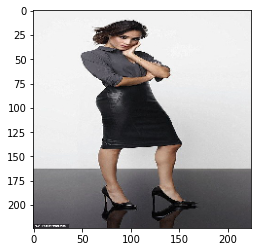

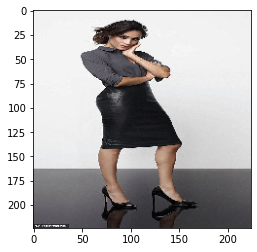

In [20]:
import matplotlib.pyplot as plt
grads = []
img_index = 1

plt.imshow((x_test[img_index]+1)/2.0)
plt.show()
plt.imshow(cv.normalize(src=x_test[img_index], dst=None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX, dtype=cv.CV_8U)
)
plt.show()

In [ ]:
grads = get_perturbed_gradient(model,x_test[img_index:img_index+1],10,noise_std=0.05,samples=100,batch_size=100)

In [14]:
sg = SMGD(grads)
sgsq = SMGD_SQ(grads)
vg = VARGD(grads)

# get 1% of the most important pixels

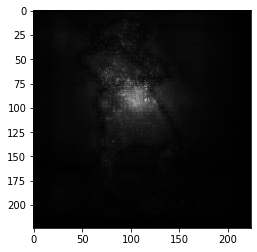

T:87.91981363165283


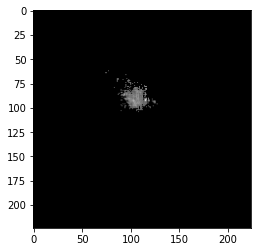

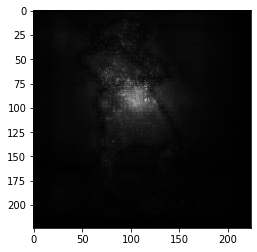

T:87.91981363165283


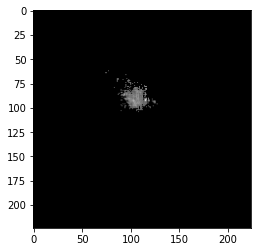

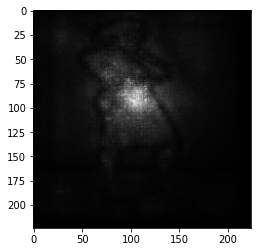

T:116.88557176814133


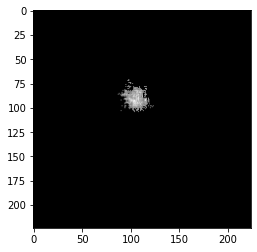

In [15]:
frac = 0.01
plt.imshow(prepare_to_display(sg),cmap='gray')
plt.show()
plt.imshow(prepare_to_display(sg,top_frac=frac),cmap='gray')
plt.show()
plt.imshow(prepare_to_display(sgsq),cmap='gray')
plt.show()
plt.imshow(prepare_to_display(sgsq,top_frac=frac),cmap='gray')
plt.show()
plt.imshow(prepare_to_display(vg),cmap='gray')
plt.show()
plt.imshow(prepare_to_display(vg,top_frac=frac),cmap='gray')
plt.show()


T:112.13359481196325
T:145.7050331581564


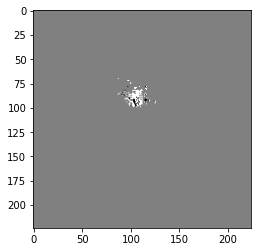

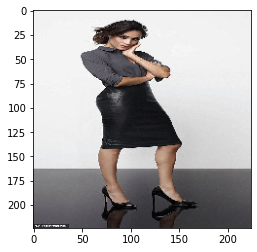

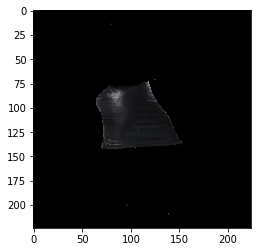

In [16]:
import cv2 as cv
from matplotlib import pyplot as plt
img = x_test[img_index]
img = cv.normalize(src=img, dst=None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX, dtype=cv.CV_8U)

mask = get_grabcut_mask(sgsq,thres1=0.005,thres2=0.001)
bgdModel = np.zeros((1,65),np.float64)
fgdModel = np.zeros((1,65),np.float64)
plt.imshow(mask/np.max(mask),cmap='gray')
plt.show()
gc_mask,fg,bg = cv.grabCut(img,mask,None,bgdModel,fgdModel,5,cv.GC_INIT_WITH_MASK)
gc_mask = np.where((gc_mask==2)|(gc_mask==0),0,1).astype('uint8')
masked_img = img*gc_mask[:,:,np.newaxis]
plt.imshow(img)
plt.show()

plt.imshow(masked_img)
plt.show()